In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math 
from PIL import Image
import imutils

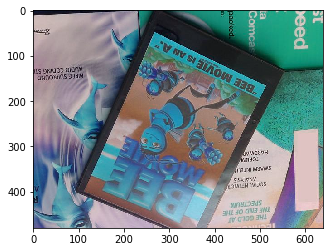

In [2]:
#loading the images
image1 = cv2.imread(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign CV\image1.jpg',1)
image2 = cv2.imread(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign CV\image2.jpg',1)
plt.imshow(image2)

In [3]:
#defining Harris detector function
def Harris(img):
        gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray1)
        ix = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
        iy = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
        ixx=np.multiply(ix,ix)
        iyy=np.multiply(iy,iy)
        ixy=np.multiply(ix,iy)
        average_ixx = cv2.GaussianBlur(ixx,(3,3),0)
        average_iyy=cv2.GaussianBlur(iyy,(3,3),0)
        average_ixy=cv2.GaussianBlur(ixy,(3,3),0)
        det=average_ixx*average_iyy-(average_ixy)**2
        trace=average_ixx+average_iyy
        C3=det-0.04*(trace)**2
        smallest = np.amin(C3)
        biggest = np.amax(C3)
        C=abs(C3) 
        #threshold=((np.absolute(smallest)+biggest)/90)
        #threshold=1554478150
        threshold=(0.01* biggest)
        #checked above thresholds
        #results are shit
        C_thresh=C>threshold
        for k in range(0,len(C)):
            for l in range (0,len(C[0])):
                if C[k][l]< threshold: 
                    C[k][l]=0
         
        A=np.zeros((len(C),len(C[0])),dtype=int)
        for m in range(3,len(C)-4):
            for n in range (3,len(C[0])-4):
                if C[m][n]>=threshold:  
                    N=np.array([[C[m-2][n-2],C[m-2][n-1],C[m-2][n],C[m-2][n+1],C[m-2][n+2]],
                               [C[m-1][n-2],C[m-1][n-1],C[m-1][n],C[m-1][n+1],C[m-1][n+2]],
                               [C[m][n-2],C[m][n-1],0,C[m][n+1],C[m][n+2]],
                               [C[m+1][n-2],C[m+1][n-1],C[m+1][n],C[m+1][n+1],C[m+1][n+2]],
                               [C[m+2][n-2],C[m+2][n-1],C[m+2][n],C[m+2][n+1],C[m+2][n+2]]])
                   # N=np.array([[C[m-1][n-1],C[m-1][n],C[m-1][n+1]],[C[m][n-1],0,C[m][n+1]],[C[m+1][n-1],C[m+1][n],C[m+1][n+1]]])                            
                    max_value=np.amax(N)
                    if C[m][n]>=max_value:
                        A[m][n]=1
                    else:
                        A[m][n]=0
        m1=np.count_nonzero(A)    
        print("Number of Corner points",m1) 
        A1 = np.float32(A)   
        img2 = np.zeros_like(img)
        img2[:,:,0] = gray
        img2[:,:,1] = gray
        img2[:,:,2] = gray

        plt.imshow(gray,cmap='gray')
        for i in range (0,len(A)):
            for j in range (0,len(A[0])):
                if A[i][j]==True :
                    plt.scatter(j,i,s=1, c='red', marker='x') #for gray image  
                    #img2[i][j]=[255,0,0] #for colored image
                    #this method is used before nms to show precise points on image
       
    
        plt.show()
        #plt.imshow(img2)            
        return A1

In [4]:
def norm(x01,y01,x02,y02):  
    n = math.sqrt((abs(x02 - x01))**2 + (abs(y02 - y01))**2)  
    return n 

In [5]:
def rotation(img,ang):
    rows = len(img) 
    cols = len(img[0])
    M = cv2.getRotationMatrix2D((cols/2,rows/2),ang,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

  
def matching_points(img,r):
        
        M=0
        X1=np.zeros((len(r),len(r[0])))
        D=np.zeros((len(r),len(r[0])))
        Y1=np.zeros((len(r),len(r[0])))
        X2=np.zeros((len(r),len(r[0])))      # rotated
        Y2=np.zeros((len(r),len(r[0])))
        for i in range (0,len(img)) :
            for j in range (0,len(img[0])) :
                if img[i][j]>0:
                    X1[i][j]=i
                    Y1[i][j]=j
                else:
                    X1[i][j]=0
                    Y1[i][j]=0
        for i in range (0,len(r)) :
            for j in range (0,len(r[0])) :
                if r[i][j]>0:
                    X2[i][j]=i
                    Y2[i][j]=j
                else:
                    X2[i][j]=0
                    Y2[i][j]=0
        for i in range (0,len(r)) :
            for j in range (0,len(r[0])) :
                if X1[i][j]!=0 or Y1[i][j]!=0 or X2[i][j]!=0 or Y2[i][j]!=0:
                    f=norm(X1[i][j],Y1[i][j],X2[i][j],Y2[i][j])
                    if f<8:
                        D[i][j]=1
                        M+=1
                    else:
                        D[i][j]=0
        M1=np.count_nonzero(D)              
                    
        return M1
                  
                  

In [6]:
def Rotation_invariant_property(img,orgimg):
    M=np.zeros(24)
    rep=np.zeros(24)
    N=np.zeros(24)
    a=np.zeros(24)
    l=0
    i=0
    for k in range (15,361,15):
        org=rotation(orgimg,k)
        N2=np.count_nonzero(org)
        rot=rotation(img,k)        
        (H_R)=Harris(rot)
        N3=np.count_nonzero(H_R)
        p=matching_points(org,H_R)
        M[l]=p
        N[l]=min(N2,N3)
        rep[l]=M[l]/N[l]
        l+=1
        if(k<361):
            a[i]=k
            i+=1        
    return M,rep,N,a

In [7]:
def plot(M,rep,N,a):
    print(M)
    print(rep)
    print(N) 
    plt.plot(a, rep, color='yellow', linestyle='dashed', linewidth = 2, 
         marker='o', markerfacecolor='blue', markersize=10) 
    plt.xlabel('Angle or Scale') 
    plt.ylabel('Repeatibility') 
    plt.title('Graph')  
    plt.show() 

In [8]:
def scaling(image,f):
    scl_factor = f 
    w = int(image.shape[1] * scl_factor )
    h = int(image.shape[0] * scl_factor )
    dim = (w, h)
    rimg=resized = cv2.resize(image, dim, interpolation = cv2.INTER_CUBIC)
    return rimg

In [9]:
def scale_variant_property(image):
   
    l=0
    M=np.zeros(9)
    rep=np.zeros(9)
    fac=np.zeros(9)
    N=np.zeros(9)
    for i in range (0,9):
        factor=1.2**(i)
        fac[l]=factor
        si=scaling(image,factor)
        sr=Harris(si)
        N3=np.count_nonzero(sr)
        if i==0:
            N2=np.count_nonzero(sr)
            himg=sr
            
        M[l]=matching_points(himg,sr)
        N[l]=min(N2,N3)
        rep[l]=M[l]/N[l]
        l+=1
    return M,N,rep,fac  

Operations on Image 1


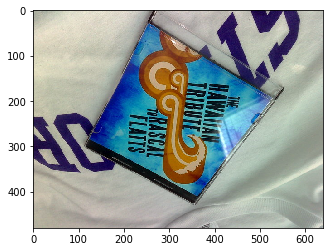

In [10]:
print("Operations on Image 1")
plt.imshow(image1)

Harris Response of Image 1
Number of Corner points 1212


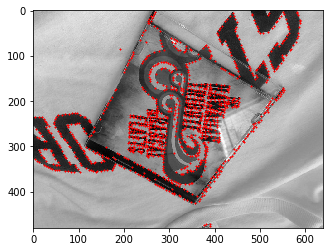

In [11]:
print("Harris Response of Image 1")
Harris_resp_im1=Harris(image1)

Rotation Invariant Property >> Image1
Number of Corner points 1416


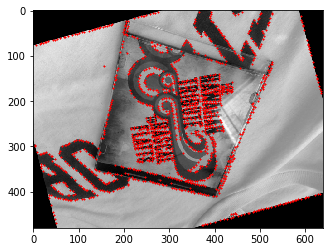

Number of Corner points 1126


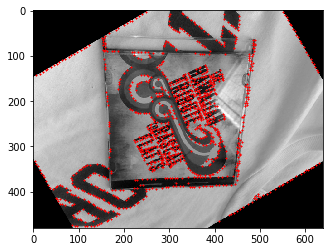

Number of Corner points 1003


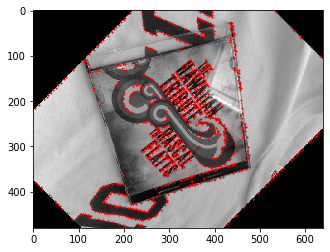

Number of Corner points 962


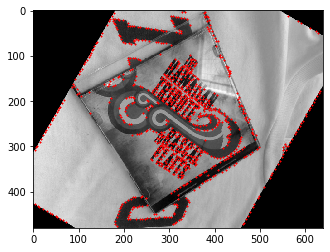

Number of Corner points 1343


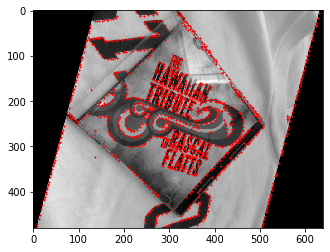

Number of Corner points 1204


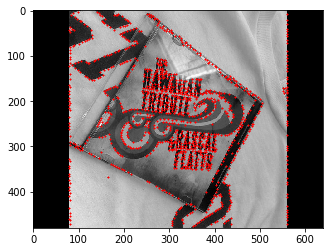

Number of Corner points 1411


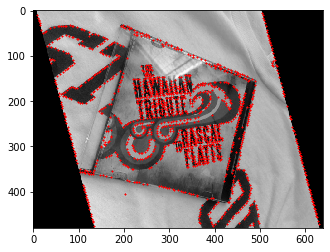

Number of Corner points 1166


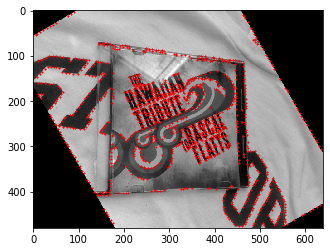

Number of Corner points 1169


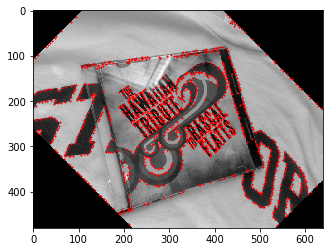

Number of Corner points 1148


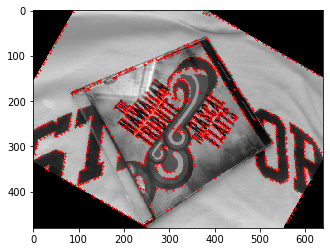

Number of Corner points 1474


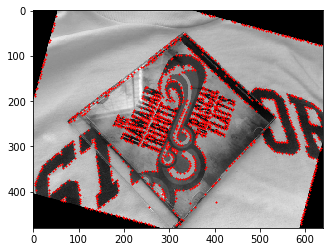

Number of Corner points 1207


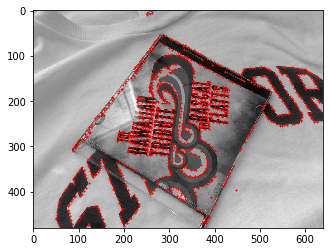

Number of Corner points 1409


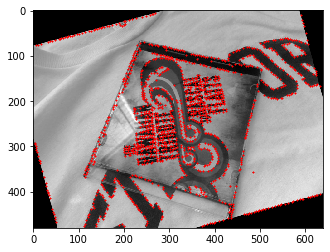

Number of Corner points 1094


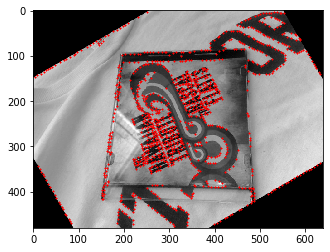

Number of Corner points 992


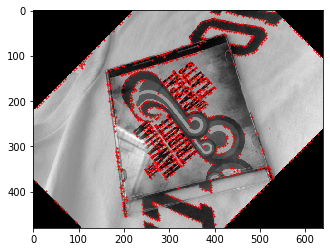

Number of Corner points 963


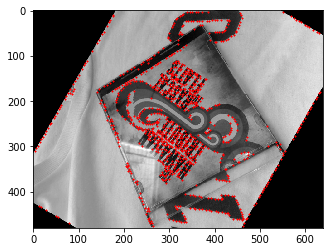

Number of Corner points 1344


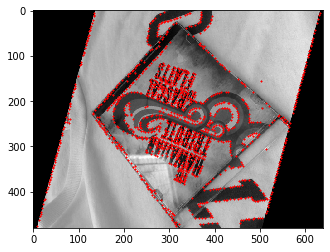

Number of Corner points 1204


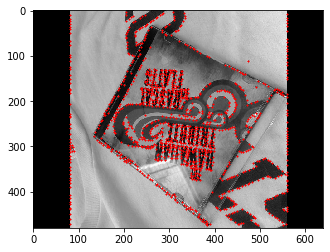

Number of Corner points 1416


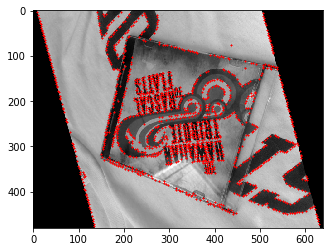

Number of Corner points 1153


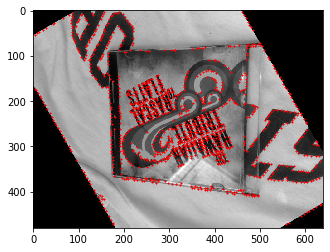

Number of Corner points 1168


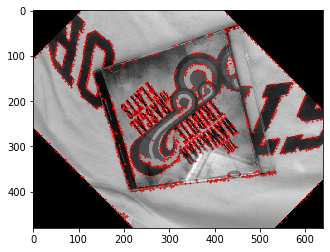

Number of Corner points 1139


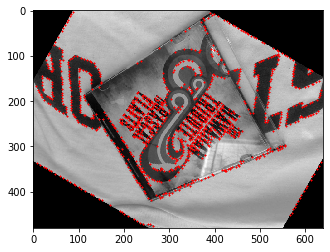

Number of Corner points 1478


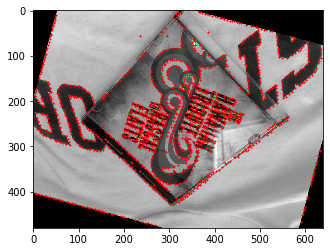

Number of Corner points 1212


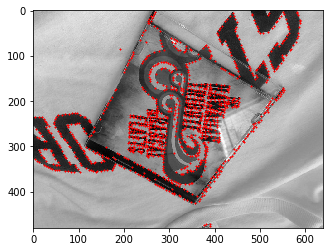

In [12]:
print("Rotation Invariant Property >> Image1")
(M1,rep1,N1,a1)=Rotation_invariant_property(image1,Harris_resp_im1)

[ 754.  712.  603.  582.  733. 1104.  753.  748.  715.  712.  821. 1207.
  752.  690.  598.  583.  732. 1104.  754.  735.  715.  703.  820. 1212.]
[0.53248588 0.63232682 0.60119641 0.6049896  0.545793   0.99280576
 0.53366407 0.64150943 0.61163388 0.62020906 0.55698779 1.
 0.53371185 0.63071298 0.60282258 0.60539979 0.54464286 0.99369937
 0.53248588 0.63746748 0.61215753 0.61720808 0.55480379 1.        ]
[1416. 1126. 1003.  962. 1343. 1112. 1411. 1166. 1169. 1148. 1474. 1207.
 1409. 1094.  992.  963. 1344. 1111. 1416. 1153. 1168. 1139. 1478. 1212.]


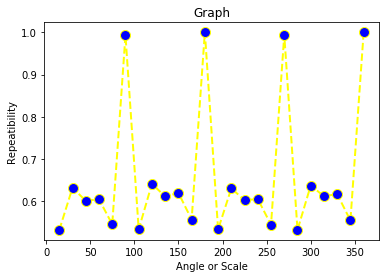

In [13]:
plot(M1,rep1,N1,a1)

Scale Variant Property >> Image1
Number of Corner points 1212


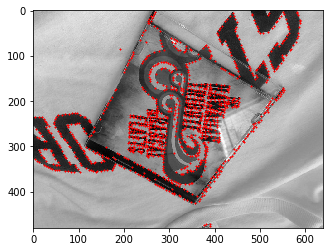

Number of Corner points 1368


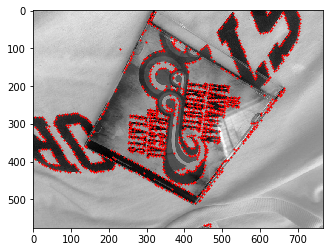

Number of Corner points 1576


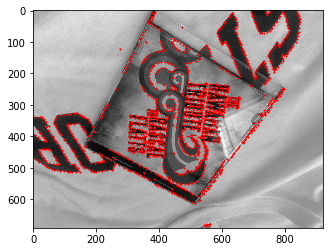

Number of Corner points 1923


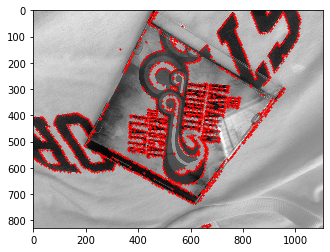

Number of Corner points 2379


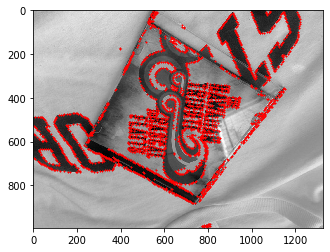

Number of Corner points 2943


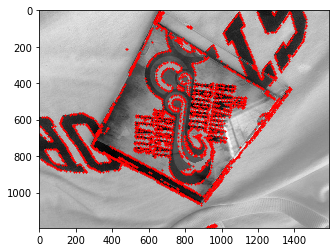

Number of Corner points 3418


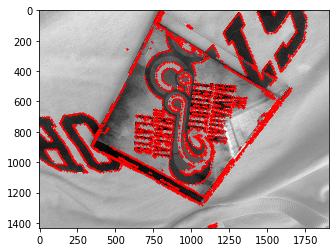

Number of Corner points 3908


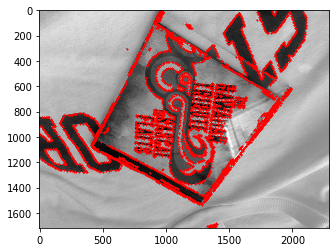

Number of Corner points 4696


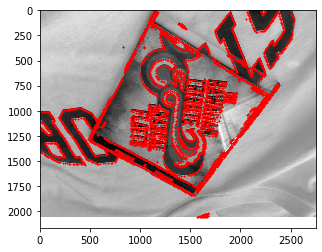

In [14]:
print("Scale Variant Property >> Image1")
(Ms,Ns,reps,fac)=scale_variant_property(image1)

[1212.   11.    7.    2.    0.    0.    0.    0.    0.]
[1.         0.00907591 0.00577558 0.00165017 0.         0.
 0.         0.         0.        ]
[1212. 1212. 1212. 1212. 1212. 1212. 1212. 1212. 1212.]


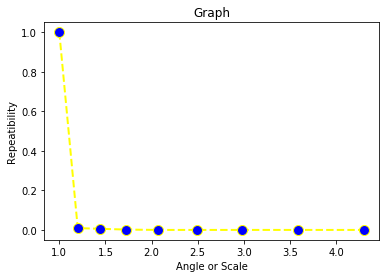

In [15]:
plot(Ms,reps,Ns,fac)

Harris Response of Image 2
Number of Corner points 624


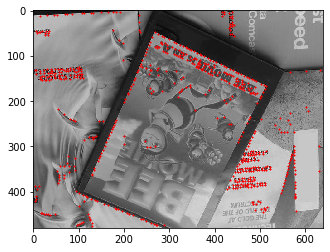

In [16]:
print("Harris Response of Image 2")
Harris_resp_im2=Harris(image2)

Rotation Invariant Property >> Image2
Number of Corner points 893


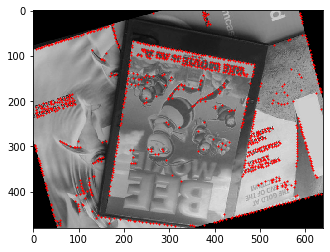

Number of Corner points 736


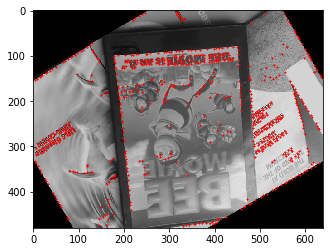

Number of Corner points 701


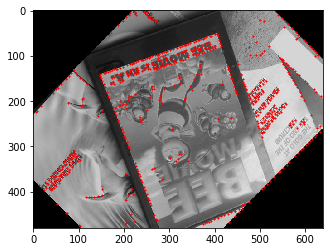

Number of Corner points 769


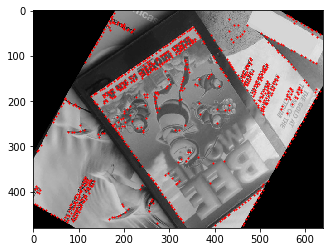

Number of Corner points 845


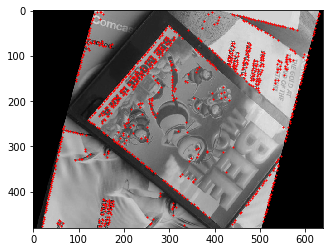

Number of Corner points 558


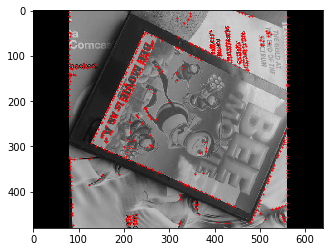

Number of Corner points 786


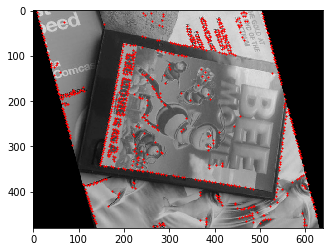

Number of Corner points 695


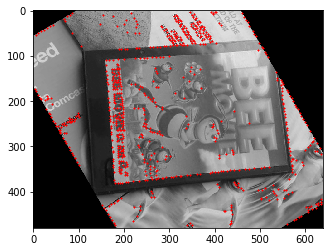

Number of Corner points 666


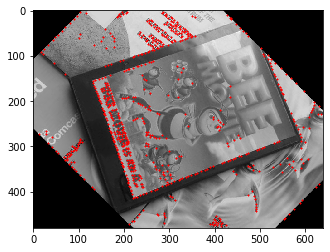

Number of Corner points 765


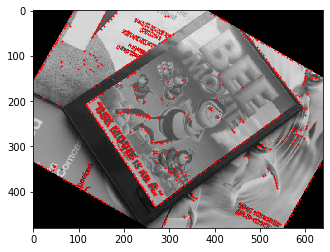

Number of Corner points 906


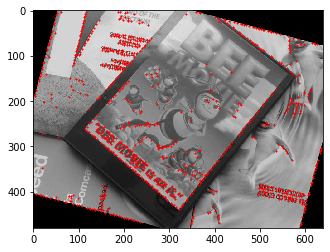

Number of Corner points 613


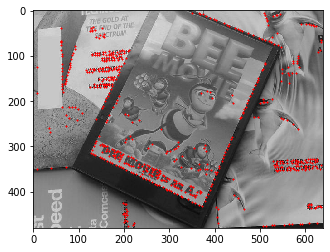

Number of Corner points 892


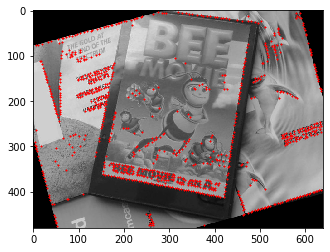

Number of Corner points 767


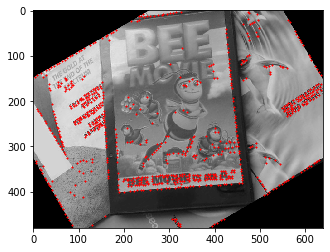

Number of Corner points 702


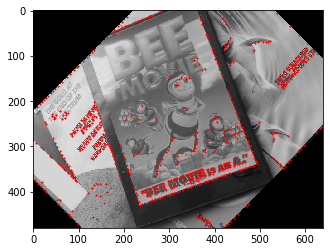

Number of Corner points 770


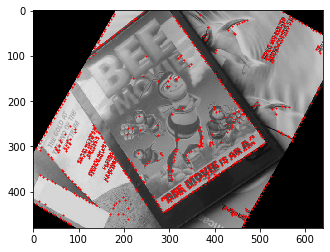

Number of Corner points 847


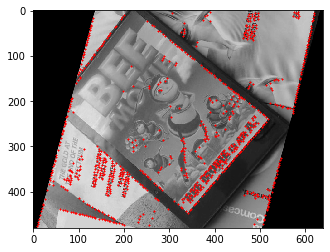

Number of Corner points 557


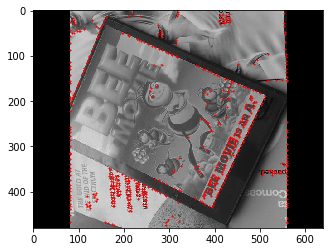

Number of Corner points 784


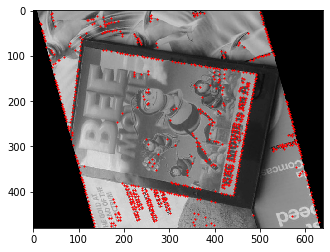

Number of Corner points 620


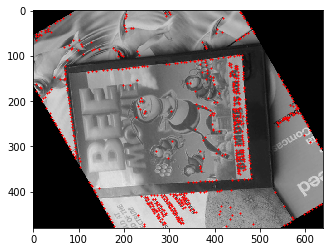

Number of Corner points 665


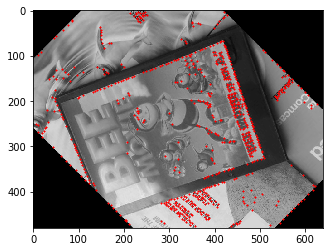

Number of Corner points 766


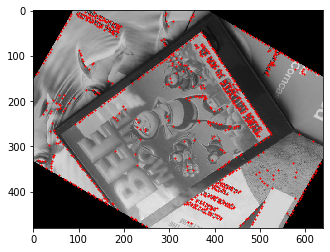

Number of Corner points 899


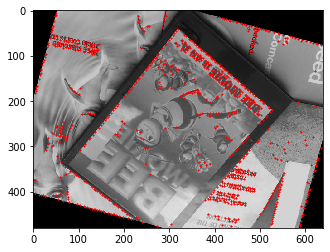

Number of Corner points 624


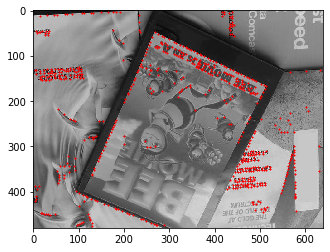

In [17]:
print("Rotation Invariant Property >> Image2")
(M2,rep2,N2,a2)=Rotation_invariant_property(image2,Harris_resp_im2)

[438. 394. 412. 402. 388. 482. 379. 346. 364. 396. 436. 613. 439. 395.
 411. 403. 388. 481. 374. 343. 363. 398. 434. 624.]
[0.49048152 0.53532609 0.58773181 0.52275683 0.4591716  0.98367347
 0.4821883  0.49784173 0.54654655 0.51764706 0.4812362  1.
 0.49215247 0.51499348 0.58547009 0.52337662 0.45808737 0.9796334
 0.47704082 0.55322581 0.54586466 0.51958225 0.48275862 1.        ]
[893. 736. 701. 769. 845. 490. 786. 695. 666. 765. 906. 613. 892. 767.
 702. 770. 847. 491. 784. 620. 665. 766. 899. 624.]


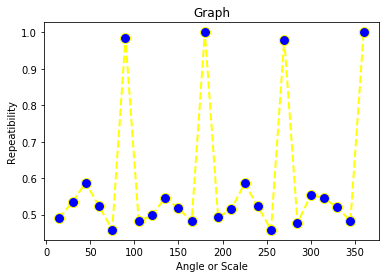

In [18]:
plot(M2,rep2,N2,a2)

Scale Variant Property >> Image2
Number of Corner points 624


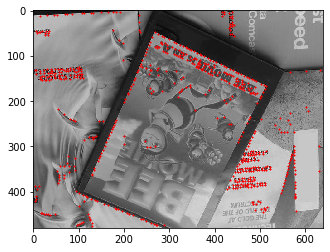

Number of Corner points 659


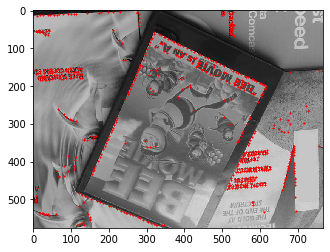

Number of Corner points 776


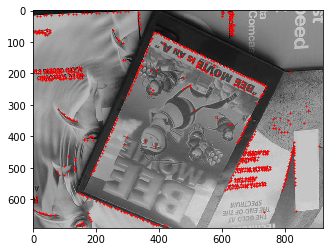

Number of Corner points 1088


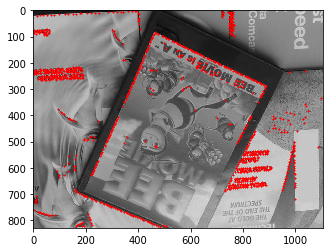

Number of Corner points 1374


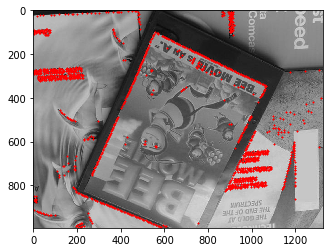

Number of Corner points 1657


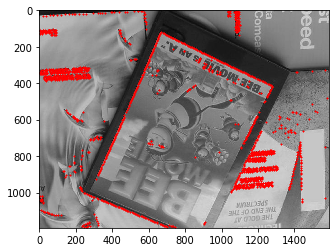

Number of Corner points 1891


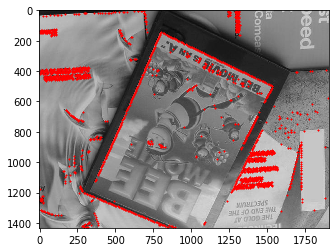

Number of Corner points 2228


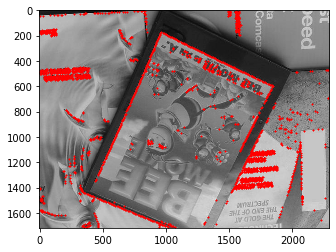

Number of Corner points 2728


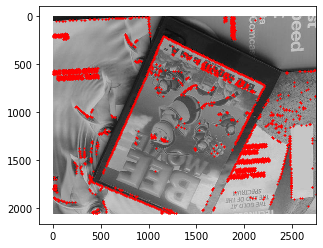

In [19]:
print("Scale Variant Property >> Image2")
(Ms2,Ns2,reps2,fac2)=scale_variant_property(image2)

[624.   4.   0.   1.   0.   1.   2.   0.   0.]
[1.         0.00641026 0.         0.00160256 0.         0.00160256
 0.00320513 0.         0.        ]
[624. 624. 624. 624. 624. 624. 624. 624. 624.]


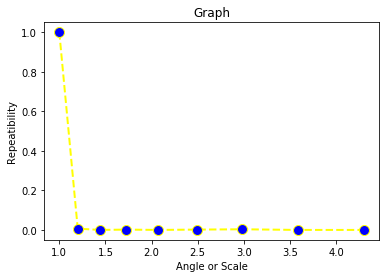

In [20]:
plot(Ms2,reps2,Ns2,fac2)